In [133]:
# Imports for this lab

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, BaggingRegressor, RandomForestRegressor
from sklearn.datasets import make_classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, roc_curve, ConfusionMatrixDisplay
from IPython.display import display, Image
from functools import reduce
from scipy import stats
from xgboost import XGBClassifier

%matplotlib inline


In [112]:
df = pd.read_csv("2022_Competition_Training.csv")
df.shape

/Users/ryanli/opt/miniconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (760) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


(48300, 881)

In [113]:
# select numerical columns
df_numeric = df.select_dtypes(include=[np.number])
numeric_cols = df_numeric.columns.values
# select non-numeric columns
df_non_numeric = df.select_dtypes(exclude=[np.number])
non_numeric_cols = df_non_numeric.columns.values

In [114]:
# % of values missing in each column
values_list = list()
cols_list = list()
for col in df.columns:
    pct_missing = np.mean(df[col].isnull())*100
    cols_list.append(col)
    values_list.append(pct_missing)
pct_missing_df = pd.DataFrame()
pct_missing_df['col'] = cols_list
pct_missing_df['pct_missing'] = values_list

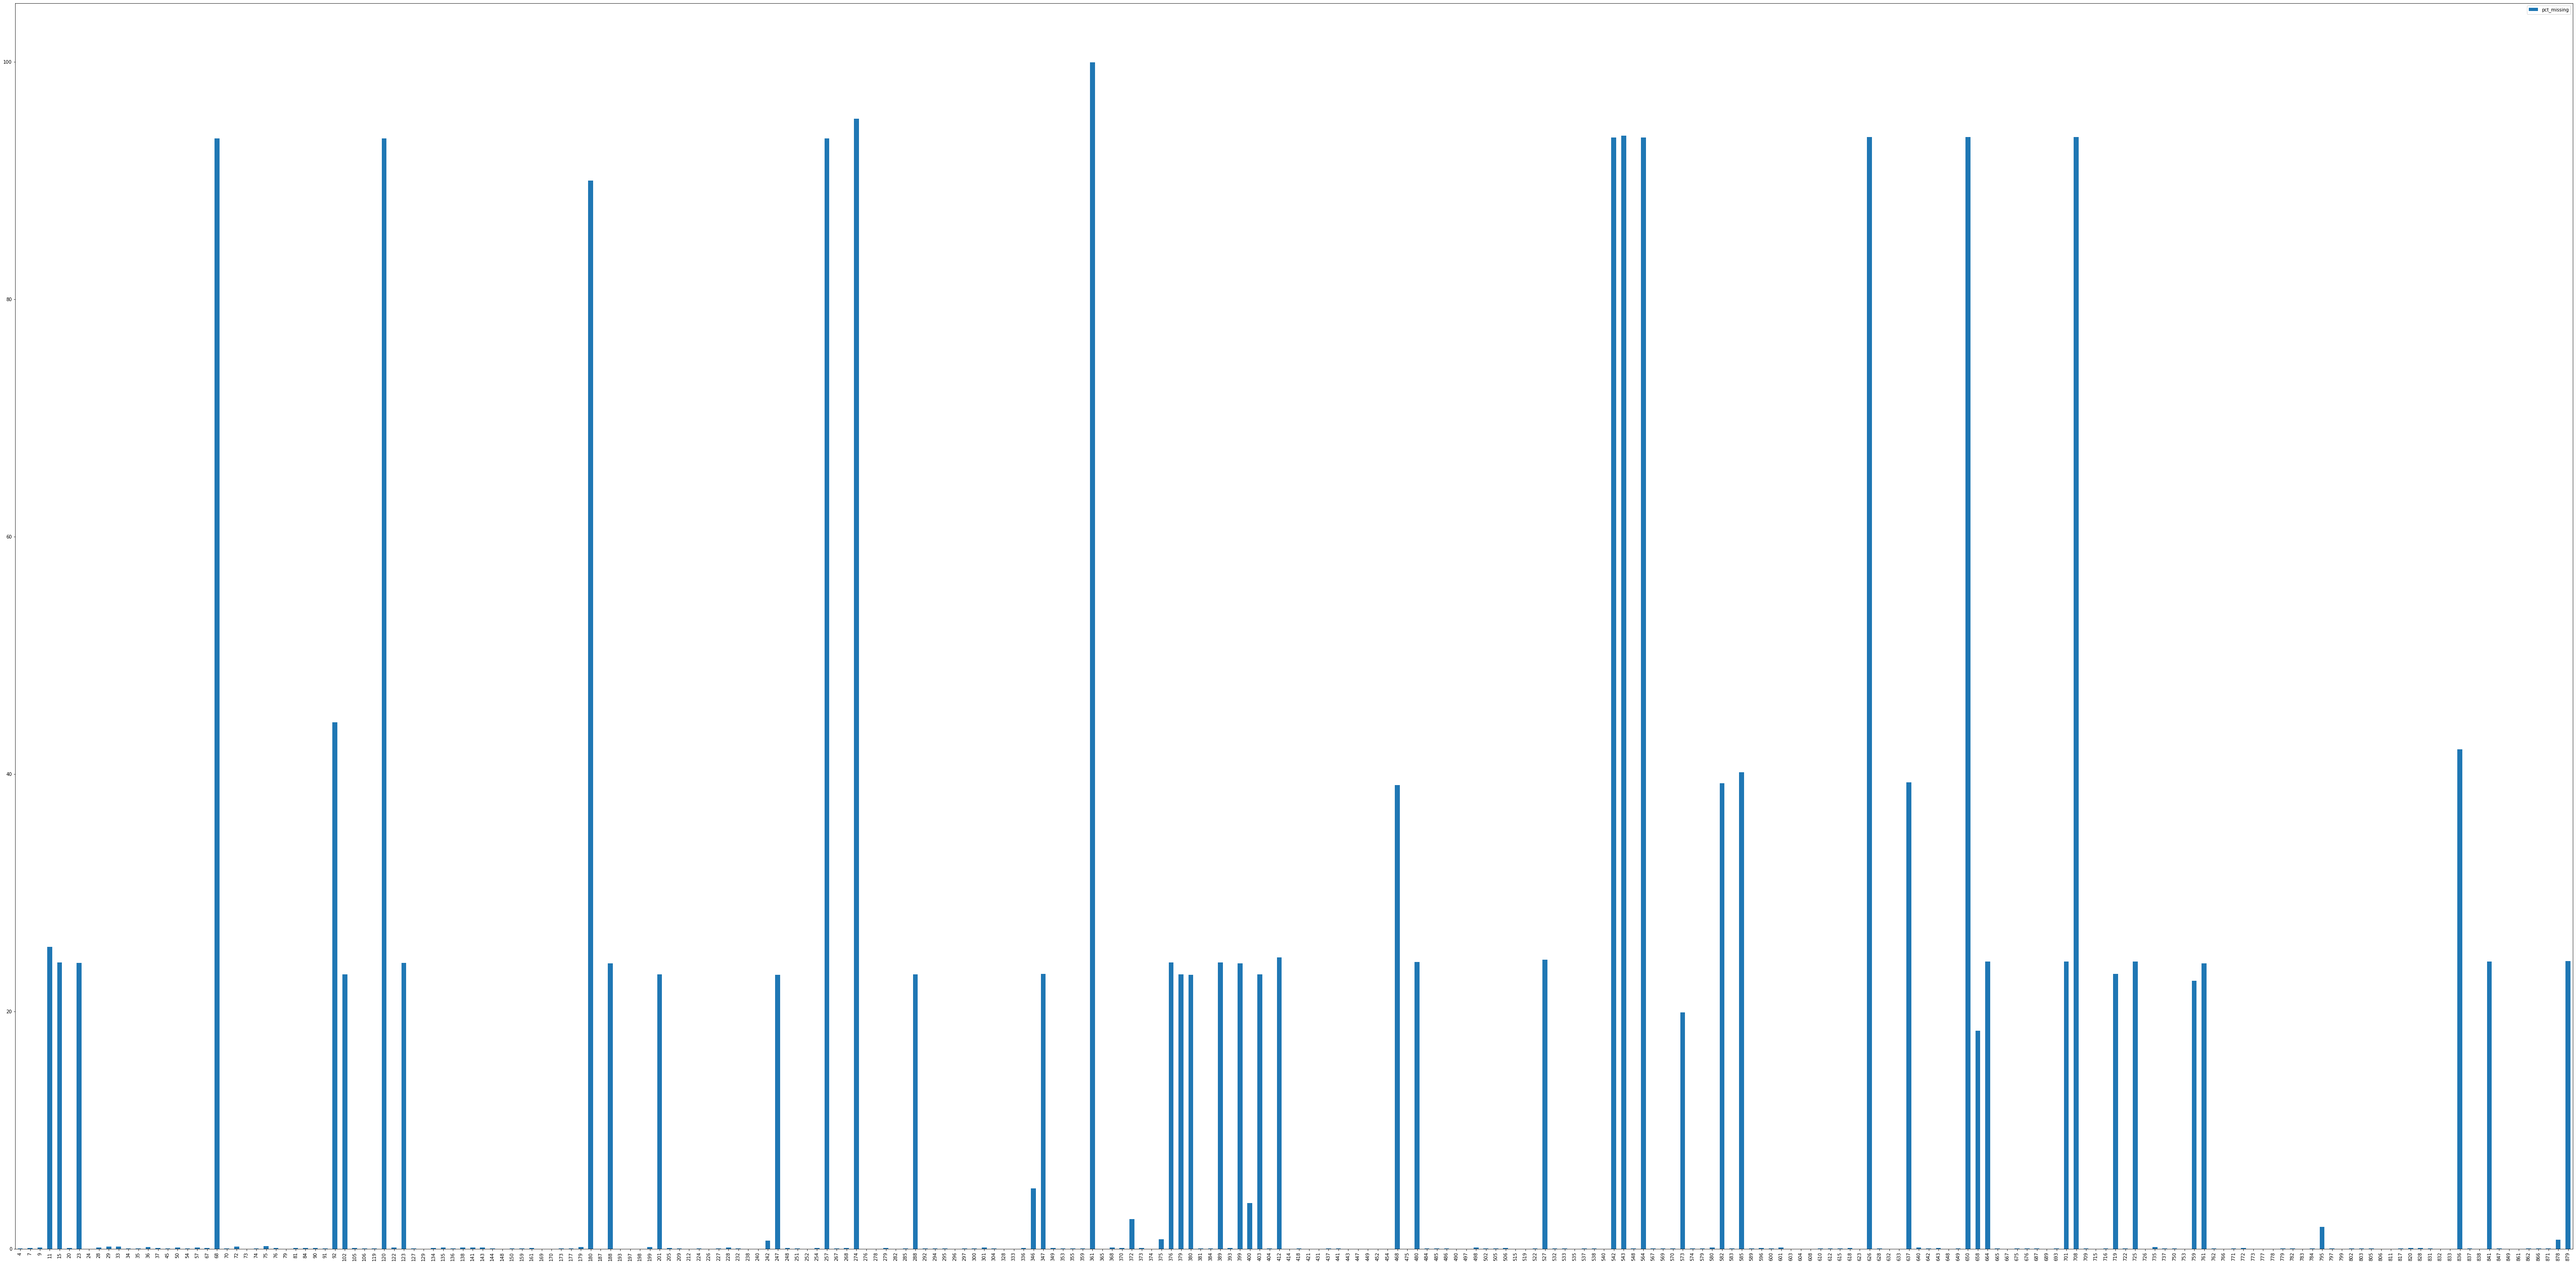

In [115]:
pct_missing_df.loc[pct_missing_df.pct_missing > 0].plot(kind='bar', figsize=(100,50))
plt.show()

In [116]:
# dropping columns with more than 40% null values
_60_pct_missing_cols_list = list(pct_missing_df.loc[pct_missing_df.pct_missing > 60, 'col'].values)
df.drop(columns=_60_pct_missing_cols_list, inplace=True)

In [117]:
df_numeric = df.select_dtypes(include=[np.number])
numeric_cols = df_numeric.columns.values
for col in numeric_cols:
    missing = df[col].isnull()
    num_missing = np.sum(missing)
    if num_missing > 0:  # impute values only for columns that have missing values
        med = df[col].median() #impute with the median
        df[col] = df[col].fillna(med)

In [118]:
df_non_numeric = df.select_dtypes(exclude=[np.number])
non_numeric_cols = df_non_numeric.columns.values
for col in non_numeric_cols:
    missing = df[col].isnull()
    num_missing = np.sum(missing)
    if num_missing > 0:  # impute values only for columns that have missing values
        mod = df[col].describe()['top'] # impute with the most frequently occuring value
        df[col] = df[col].fillna(mod)

In [119]:
df = pd.get_dummies(df)
df.shape

(48300, 908)

In [120]:
df['hi_flag'].value_counts()

0    46182
1     2118
Name: hi_flag, dtype: int64

In [121]:
y = df.hi_flag
X = df.drop(['hi_flag','id'], axis=1).select_dtypes(exclude=['object'])
train_X, test_X, train_y, test_y = train_test_split(X.values, y.values, test_size=0.1)

In [122]:
from imblearn.under_sampling import RandomUnderSampler
undersample = RandomUnderSampler(sampling_strategy='majority')
X_train_under, y_train_under = undersample.fit_resample(train_X, train_y)


In [123]:
rf = RandomForestClassifier(n_estimators=1000, criterion='gini', max_depth=None, n_jobs=-1, random_state=0)

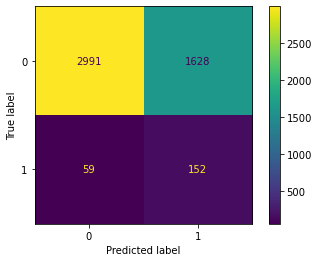

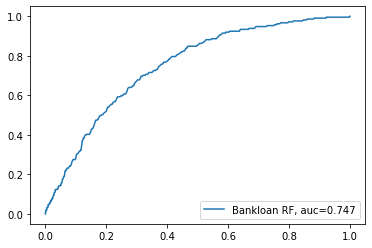

In [124]:
#train_X, test_X, train_y, test_y 

rf.fit(X_train_under, y_train_under)
rf_ypr = rf.predict(test_X)

rf_yprob = rf.predict_proba(test_X)

# Let's evaluate our RF
conf = confusion_matrix(test_y,rf_ypr)
ConfusionMatrixDisplay(conf).plot()
plt.show()

# Calculate the ROC curve points
fpr, tpr, _ = roc_curve(test_y, rf_yprob[:,1]) #just take yprob of positive class

# Save the AUC in a variable to display it. Round it first
auc = np.round(roc_auc_score(y_true = test_y, y_score = rf_yprob[:,1]), decimals = 3)

# Create and show the plot
plt.plot(fpr,tpr,label=f"RF, auc={auc}")
plt.legend(loc=4)
plt.show()

In [77]:
# import sys
# import numpy
# numpy.set_printoptions(threshold=sys.maxsize)
# rf_ypr


In [131]:
# We now create and fit trees from max depth 1 to max depth 40. 
# The purpose is to compute accuracy score and the scoring method is cross validation.


# #train_X, test_X, train_y, test_y 
from sklearn.pipeline import Pipeline
a=[]
b=[]
for i in range(1,20):
    M = Pipeline([('dt',DecisionTreeClassifier(max_depth = i))])
    acc = cross_val_score(M,train_X,train_y,cv=5).mean()
    a.append(i)
    b.append(acc)
    print(f'CV classification accuracy with depth {i}:{acc}')

# Plot the CV score and maximum depth 
plt.scatter(a,b)

# Print the optimal max depth for the decision tree
print(f'The optimal depth is {b.index(max(b))+1}')

CV classification accuracy with depth 1:0.9561306648263169
CV classification accuracy with depth 2:0.9559696342305039
CV classification accuracy with depth 3:0.9560156429721648
CV classification accuracy with depth 4:0.9554405337014034
CV classification accuracy with depth 5:0.9546813894639982
CV classification accuracy with depth 6:0.9545893719806763
CV classification accuracy with depth 7:0.9541982976765585
CV classification accuracy with depth 8:0.9534851621808142
CV classification accuracy with depth 9:0.9529330572808835
CV classification accuracy with depth 10:0.9521048999309869
CV classification accuracy with depth 11:0.9510006901311249
CV classification accuracy with depth 12:0.9502415458937199
CV classification accuracy with depth 13:0.949206349206349
CV classification accuracy with depth 14:0.9488152749022314
CV classification accuracy with depth 15:0.9479871175523348
CV classification accuracy with depth 16:0.9469749252357949
CV classification accuracy with depth 17:0.9463538

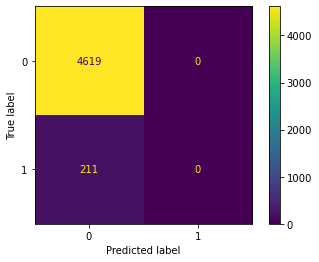

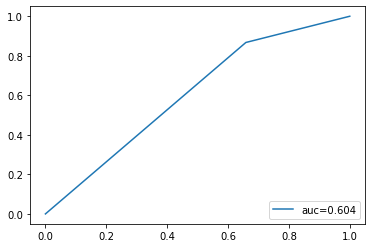

In [134]:
DTCtree = DecisionTreeClassifier(max_depth=1)
DTCtree.fit(train_X, train_y)
ypr = DTCtree.predict(test_X)
yprob = DTCtree.predict_proba(test_X)
# Plot confusion and ROC, compare with RF
conf = confusion_matrix(test_y,ypr)
ConfusionMatrixDisplay(conf).plot()
plt.show()
# Calculate the ROC curve points
fpr2, tpr2, _ = roc_curve(test_y, yprob[:,1]) #just take yprob of positive class

# Save the AUC in a variable to display it. Round it first
auc2 = np.round(roc_auc_score(y_true = test_y, y_score = yprob[:,1]), decimals = 3)

# Create and show the plot
plt.plot(fpr2,tpr2,label=f"auc={auc2}")
plt.legend(loc=4)
plt.show()

In [82]:
# param_grid = dict({'n_estimators': [50, 1000],'max_depth': [1,10],'learning_rate' : [0.01, 0.1]})

# grid = GridSearchCV(gb, param_grid, cv = 5, scoring = 'roc_auc', n_jobs = -1)
# grid.fit(X_train_under,y_train_under)

In [79]:
#display(grid.best_params_)

In [125]:
gbF = XGBClassifier(max_depth=1, learning_rate=0.1, n_estimators=1000, booster='gbtree',n_jobs=1, gamma=0.001, seed = 166)

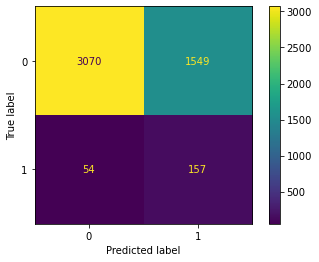

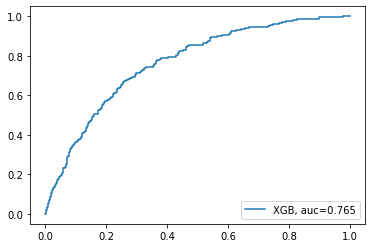

In [126]:
# Train and test
import matplotlib.pyplot as plt

gbF = gbF.fit(X_train_under,y_train_under)
ypr = gbF.predict(test_X)
yprob = gbF.predict_proba(test_X)

# Plot confusion and ROC, compare with RF
conf = confusion_matrix(test_y,ypr)
ConfusionMatrixDisplay(conf).plot()
plt.show()

# Calculate the ROC curve points
fpr2, tpr2, _ = roc_curve(test_y, yprob[:,1]) #just take yprob of positive class

# Save the AUC in a variable to display it. Round it first
auc2 = np.round(roc_auc_score(y_true = test_y, y_score = yprob[:,1]), decimals = 3)

# Create and show the plot
plt.plot(fpr2,tpr2,label=f"XGB, auc={auc2}")
plt.legend(loc=4)

plt.show()


In [127]:
df_holdout = pd.read_csv('2022_Competition_Holdout.csv')

df_holdout.drop(columns=_60_pct_missing_cols_list, inplace=True)
df_holdout = pd.get_dummies(df_holdout)

id = df_holdout.id

X_H = df_holdout.drop(['id'], axis=1).select_dtypes(exclude=['object']).values
X_H.shape

/Users/ryanli/opt/miniconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (760) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


(12220, 906)

In [128]:
hold_out_pre_prob = gbF.predict_proba(X_H)

In [129]:
def get_xgb_imp(xgb, var_n):
    from numpy import array
    imp_vals = xgb.booster().get_fscore()
    imp_dict = {var_n[i]:float(imp_vals.get('f'+str(i),0.)) for i in range(len(var_n))}
    total = array(imp_dict.values()).sum()
    return {k:v/total for k,v in imp_dict.items()}

attributes = list(X.columns)
gbF.feature_importances_



array([0.        , 0.00214858, 0.        , 0.        , 0.00276989,
       0.        , 0.        , 0.        , 0.        , 0.00255138,
       0.00269761, 0.        , 0.        , 0.        , 0.00194141,
       0.        , 0.00607338, 0.00280546, 0.        , 0.        ,
       0.        , 0.00204023, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.0022987 ,
       0.00424141, 0.00414258, 0.        , 0.        , 0.        ,
       0.0021239 , 0.        , 0.        , 0.        , 0.00252758,
       0.00272304, 0.        , 0.00234424, 0.00242476, 0.00264147,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.00270261, 0.        , 0.        , 0.00243505, 0.        ,
       0.        , 0.        , 0.00289909, 0.00349762, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.00258933,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

                                     variable     value
393                             cons_stlindex  0.103258
212                                   est_age  0.039068
678  total_physician_office_allowed_pmpm_cost  0.033453
526                        cms_low_income_ind  0.029186
100                               cons_hxmioc  0.024354
390                  cms_orig_reas_entitle_cd  0.022474
197                               cons_hxmboh  0.020895
281                             cons_stlnindx  0.013378
715                           cms_frailty_ind  0.012898
413                         rx_hum_24_pmpm_ct  0.012174
399                     med_outpatient_ds_clm  0.011828
741                  rwjf_median_house_income  0.010883
392                          atlas_totalocchu  0.010444
719               cmsd2_skn_radiation_pmpm_ct  0.009751
767                     cmsd2_men_mad_pmpm_ct  0.009555
876                            cons_homstat_Y  0.009464
760                         cmsd1_men_pmpm_ct  0

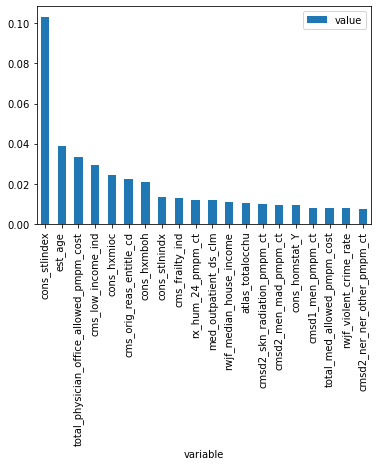

In [130]:
df_imp = pd.DataFrame([gbF.feature_importances_], columns = attributes)
df_imp = pd.melt(df_imp, value_vars=attributes)
df_imp = df_imp.sort_values(by=['value'],ascending=False)
df_imp = df_imp[:20]
print(df_imp[:20])
plt = df_imp.plot.bar(x='variable')

In [80]:
Prob_df = pd.DataFrame(hold_out_pre_prob)
Index_Prob_df = pd.concat([id, Prob_df], axis=1)
Index_Prob = Index_Prob_df.drop(0,axis=1)
Index_Prob

,id,1
0,100093066.0,0.397038
1,100313000.0,0.511809
2,100330875.0,0.454670
3,100346385.0,0.301110
4,100443164.0,0.285797
...,...,...
12215,999896529.0,0.475475
12216,999899065.0,0.650275
12217,999946210.0,0.408426
12218,999984658.0,0.470805


In [83]:
Index_Prob['rank'] = Index_Prob[1].rank(ascending = False)

In [85]:
Index_Prob.to_excel("CC_output.xlsx")  